In [ ]:
import kagglehub

# download dataset from kaggle via kagglehub api
path = kagglehub.dataset_download("balraj98/massachusetts-roads-dataset")

print("Path to dataset files:", path)

c:\Users\TYC\Desktop\python code\satellite_road_seg\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 5.76G/5.76G [05:04<00:00, 20.3MB/s] 

Extracting files...


Path to dataset files: C:\Users\TYC\.cache\kagglehub\datasets\balraj98\massachusetts-roads-dataset\versions\1


In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image
#importing libraries for image display and processing


In [5]:
#path
image_dir = "./MA_road_data/tiff/test"
mask_dir = "./MA_road_data/tiff/test_labels"

#make list of files
image_files = os.listdir(image_dir)
mask_files = os.listdir(mask_dir)

print(f"Number of images: {len(image_files)}")
print(f"Number of masks: {len(mask_files)}")

Number of images: 49
Number of masks: 49


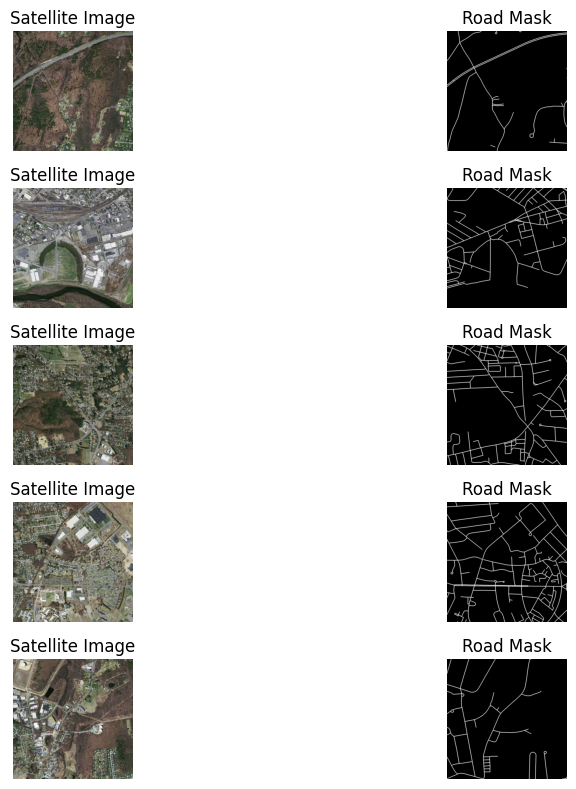

In [6]:
#pick first 5 images and masks to display

plt.figure(figsize=(12,8))
for i, idx in enumerate(range(5)):

    img_path = os.path.join(image_dir, image_files[idx])
    mask_path = os.path.join(mask_dir, mask_files[idx])

    image=Image.open(img_path)
    mask=Image.open(mask_path)

    #plot image
    plt.subplot(5, 2, i*2+1)
    plt.imshow(image)
    plt.title("Satellite Image")
    plt.axis('off')

    #plot mask
    plt.subplot(5, 2, i*2+2)
    plt.imshow(mask, cmap='gray')
    plt.title("Road Mask")  
    plt.axis('off')

plt.tight_layout()
plt.show()